In [1]:
# # Instalar libreria tabula
# ! pip install -q tabula-py
# ! pip install alphacast 

In [2]:
# Importacion de librerias
import pandas as pd
import requests
import tabula
import datetime
import matplotlib.pyplot as plt
from lxml import html
from sklearn.linear_model import LinearRegression
from scipy.interpolate import make_interp_spline

In [3]:
from alphacast import Alphacast
with open ('ApiKey.csv', 'r') as API_key:
    API_key = API_key.readline().strip()
alphacast = Alphacast(API_key)

# Creacion Repositorio en Alphacast

In [4]:
# respositorio = alphacast.repository.create("Proyectos_DS", repo_description="Data_Science", slug="DS"
#                                            , privacy="Public", returnIdIfExists=True)

# Creacion del dataset en Alphacast

In [5]:
# alphacast.datasets.create("Bonos_Dolares", 1162, "Proyectos_DS")
# alphacast.datasets.create("Bonos_Pesos", 1162, "Proyectos_DS")

# Metadatos del dataset creado

In [6]:
# alphacast.datasets.dataset(7961).metadata()

# Inicializacion columnas dataset creado

In [7]:
# alphacast.datasets.dataset(7961).initialize_columns(dateColumnName = "Fecha", entitiesColumnNames=["Codigo"],
#                                                     dateFormat= "%Y-%m-%d")
# alphacast.datasets.dataset(7973).initialize_columns(dateColumnName = "Fecha_Cotizacion", entitiesColumnNames=["Codigo"],
#                                                     dateFormat= "%Y-%m-%d")

# Estados de los procesos ejecutas a la fecha en Alphacast

In [8]:
# alphacast.datasets.dataset(7961).processes()
# alphacast.datasets.dataset(7973).processes()

In [9]:
import time
inicio = time.time()

# Armado de algoritmo de parseo de datos de IAMC-BYMA + Graficas

In [10]:
url = "https://www.iamc.com.ar/informediario/"
url_bonos_pesos = "https://www.byma.com.ar/wp-admin/admin-ajax.php?action=get_bonos"

In [11]:
encabezados  = {"user-agent" : "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}

In [12]:
def conexion(url, encabezados):
    #url = url
    #encabezados  = {"user-agent" : "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}
    encabezados = encabezados
    response = requests.get(url,  headers = encabezados)
    parser  =  html.fromstring (response.text)
    pdf_path = parser.xpath ("//div[@class='contenidoListado Acceso-Rapido']//a/@href")
    
    return pdf_path

In [13]:
conexion = conexion(url, encabezados)

In [14]:
def pre_armado_excepcion(url, area=[0, 0, 96, 150]):
    df1 = tabula.read_pdf(url, pages="5", lattice=False,area=area, relative_area=True, multiple_tables=True)
    df= df1[0].iloc[25:50]
    df = df.dropna(subset=['Unnamed: 1'])
    df = df.dropna(axis=1)

        #             fecha = url_a.replace("/", "    ").strip()
        #             fecha = fecha[75:90].strip()

    #fecha = url[-28:-18].replace("/", "").replace("_", "").strip()
    fecha = url.replace("/", "-")[-29:-19].replace("_", "-").lstrip("c-")
    if len(df.columns)==11:
        df = df.drop([df.columns[3]], axis=1)
        prox_vencim = []
        vr_en_porcent = []
        cot_c_100_nom = []
        fecha_ult_act = []
        renta_anual_en_porc = []
                        #int_corridos = []
        volatilidad = []
        tir_anual = []
        dm = []
        for l in (df.iloc[:,3].apply(lambda x: str(x).split(" "))):
            prox_vencim.append(l[0])
            vr_en_porcent.append(l[2])
            cot_c_100_nom.append(l[3])
            fecha_ult_act.append(l[4])
                            #int_corridos.append(l[5])
            renta_anual_en_porc.append(l[5])
        df["Prox_Vto"] = prox_vencim
        df["VR (en %)"] = vr_en_porcent
        df["Cotiz. c/100 nom."] = cot_c_100_nom
        df["Ult. Actualizacion"] = fecha_ult_act
        df["Renta anual (en %)"] = renta_anual_en_porc
                        #df["Int. corridos c/100 vn"] = int_corridos

        for l in (df["www.iamc.com.ar"].apply(lambda x: str(x).split(" "))):
            volatilidad.append(l[0])
            tir_anual.append(l[1])
            dm.append(l[2])
        df["Volatilidad_40r (en %)"] = volatilidad
        df["TIR_anual"] = tir_anual
        df["DM"] = dm

        codigo = df.iloc[:,0].apply(lambda x: x[-5:].strip())
        df["Codigo"] = codigo
        columns = ["Bono", "Vencimiento", "Amortizacion", "borrar", "int. corridos c/100 vn", "Yield_Anual", "Valor_tecnico", 
                    "Paridad","borrar2", "PPV(en años)", "Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.",
                    "Renta anual (en %)", "Volatilidad_40r (en %)", "TIR_anual", "DM", "Codigo"]

        df.columns = columns            
        df = df[["Bono","Codigo", "Vencimiento", "Amortizacion","Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.", 
                                                "Renta anual (en %)","int. corridos c/100 vn", "Yield_Anual", "Valor_tecnico", "Paridad", "Volatilidad_40r (en %)", 
                                                "TIR_anual", "DM","PPV(en años)"]]
        df["Fecha"] = pd.to_datetime(fecha, format='%Y-%m-%d')           
        
        return df

    elif len(df.columns)==9:
        prox_vencim = []
        vr_en_porcent = []
        cot_c_100_nom = []
        fecha_ult_act = []
        renta_anual_en_porc = []
        int_corridos = []
        volatilidad = []
        tir_anual = []
        dm = []
        for l in (df.iloc[:,3].apply(lambda x: str(x).split(" "))):
            prox_vencim.append(l[0])
            vr_en_porcent.append(l[2])
            cot_c_100_nom.append(l[3])
            fecha_ult_act.append(l[4])
            int_corridos.append(l[5])
            renta_anual_en_porc.append(l[6])
        df["Prox_Vto"] = prox_vencim
        df["VR (en %)"] = vr_en_porcent
        df["Cotiz. c/100 nom."] = cot_c_100_nom
        df["Ult. Actualizacion"] = fecha_ult_act
        df["Renta anual (en %)"] = renta_anual_en_porc
        df["Int. corridos c/100 vn"] = int_corridos

        for l in (df["www.iamc.com.ar"].apply(lambda x: str(x).split(" "))):
            volatilidad.append(l[0])
            tir_anual.append(l[1])
            dm.append(l[2])
        df["Volatilidad_40r (en %)"] = volatilidad
        df["TIR_anual"] = tir_anual
        df["DM"] = dm

        codigo = df.iloc[:,0].apply(lambda x: x[-5:].strip())
        df["Codigo"] = codigo
        columns = ["Bono", "Vencimiento", "Amortizacion", "borrar", "Yield_Anual", "Valor_tecnico", "Paridad", "borrar2",
                    "PPV(en años)", "Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.", "int. corridos c/100 vn",
                    "Renta anual (en %)", "Volatilidad_40r (en %)", "TIR_anual", "DM", "Codigo"]
        df.columns = columns            
        df = df[["Bono","Codigo", "Vencimiento", "Amortizacion","Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.", 
                                                "Renta anual (en %)","int. corridos c/100 vn", "Yield_Anual", "Valor_tecnico", "Paridad", "Volatilidad_40r (en %)", 
                                                "TIR_anual", "DM","PPV(en años)"]]
        df["Fecha"] = pd.to_datetime(fecha, format='%Y-%m-%d')           
        return df            
    

In [15]:
def pre_armado_informes(area=[0, 0, 100, 100]):    
    dataframes = pd.DataFrame(columns=["Bono","Codigo", "Vencimiento", "Amortizacion","Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.",
                                       "Ult. Act.", "Renta anual (en %)","int. corridos c/100 vn", "Yield_Anual", "Valor_tecnico",
                                       "Paridad", "Volatilidad_40r (en %)", "TIR_anual", "DM","PPV(en años)", "Fecha"])    
    df_dolares_alphacast = alphacast.datasets.dataset(7961).download_data("pandas")
    list_fechas_alphacast = df_dolares_alphacast.Fecha.unique().tolist()
    list_fechas_alphacast = [pd.to_datetime(f) for f in list_fechas_alphacast]
    pdf_path = conexion
    #pdf_path = [url for url in pdf_path if pd.to_datetime(url[-28:-18].replace("/", "").replace("_", "").strip(), format='%Y%m%d') not in list_fechas_alphacast]
    pdf_path = [url for url in pdf_path if pd.to_datetime(url.replace("/", "-")[-29:-19].replace("_", "-").lstrip("c-"), format='%Y-%m-%d') not in list_fechas_alphacast]
    #pdf_path = pdf_path[0]
    #df_dolares_actual = pd.read_excel(r'D:\Desktop\Todas mis cosas\Proyectos Albert\bonos_dolares_backup.xlsx')
    for url in pdf_path:
        try:           
           
            df1 = tabula.read_pdf(url, pages="5", lattice=False,area=area, relative_area=True, multiple_tables=True)
            df= df1[0].iloc[25:50]
            df = df.dropna(subset=['Unnamed: 1'])
            df = df.dropna(axis=1)
            
#             fecha = url_a.replace("/", "    ").strip()
#             fecha = fecha[75:90].strip()

            #fecha = url[-28:-18].replace("/", "").replace("_", "").strip()
            fecha = url.replace("/", "-")[-29:-19].replace("_", "-").lstrip("c-")
            if (len(df.columns)==11):
                df = df.drop([df.columns[3]], axis=1)
                prox_vencim = []
                vr_en_porcent = []
                cot_c_100_nom = []
                fecha_ult_act = []
                renta_anual_en_porc = []
                #int_corridos = []
                volatilidad = []
                tir_anual = []
                dm = []
                for l in (df.iloc[:,3].apply(lambda x: str(x).split(" "))):
                    prox_vencim.append(l[0])
                    vr_en_porcent.append(l[2])
                    cot_c_100_nom.append(l[3])
                    fecha_ult_act.append(l[4])
                    #int_corridos.append(l[5])
                    renta_anual_en_porc.append(l[5])
                df["Prox_Vto"] = prox_vencim
                df["VR (en %)"] = vr_en_porcent
                df["Cotiz. c/100 nom."] = cot_c_100_nom
                df["Ult. Actualizacion"] = fecha_ult_act
                df["Renta anual (en %)"] = renta_anual_en_porc
                #df["Int. corridos c/100 vn"] = int_corridos

                for l in (df["www.iamc.com.ar"].apply(lambda x: str(x).split(" "))):
                    volatilidad.append(l[0])
                    tir_anual.append(l[1])
                    dm.append(l[2])
                df["Volatilidad_40r (en %)"] = volatilidad
                df["TIR_anual"] = tir_anual
                df["DM"] = dm

                codigo = df.iloc[:,0].apply(lambda x: x[-5:].strip())
                df["Codigo"] = codigo
                columns = ["Bono", "Vencimiento", "Amortizacion", "borrar", "int. corridos c/100 vn", "Yield_Anual", "Valor_tecnico", 
                           "Paridad","borrar2", "PPV(en años)", "Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.",
                           "Renta anual (en %)", "Volatilidad_40r (en %)", "TIR_anual", "DM", "Codigo"]

                df.columns = columns            
                df = df[["Bono","Codigo", "Vencimiento", "Amortizacion","Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.", 
                                        "Renta anual (en %)","int. corridos c/100 vn", "Yield_Anual", "Valor_tecnico", "Paridad", "Volatilidad_40r (en %)", 
                                        "TIR_anual", "DM","PPV(en años)"]]
                df["Fecha"] = pd.to_datetime(fecha, format='%Y-%m-%d')           
                dataframes = pd.concat([dataframes, df])

            elif (len(df.columns)==9):
                prox_vencim = []
                vr_en_porcent = []
                cot_c_100_nom = []
                fecha_ult_act = []
                renta_anual_en_porc = []
                int_corridos = []
                volatilidad = []
                tir_anual = []
                dm = []
                for l in (df.iloc[:,3].apply(lambda x: str(x).split(" "))):
                    prox_vencim.append(l[0])
                    vr_en_porcent.append(l[2])
                    cot_c_100_nom.append(l[3])
                    fecha_ult_act.append(l[4])
                    int_corridos.append(l[5])
                    renta_anual_en_porc.append(l[6])
                df["Prox_Vto"] = prox_vencim
                df["VR (en %)"] = vr_en_porcent
                df["Cotiz. c/100 nom."] = cot_c_100_nom
                df["Ult. Actualizacion"] = fecha_ult_act
                df["Renta anual (en %)"] = renta_anual_en_porc
                df["Int. corridos c/100 vn"] = int_corridos

                for l in (df["www.iamc.com.ar"].apply(lambda x: str(x).split(" "))):
                    volatilidad.append(l[0])
                    tir_anual.append(l[1])
                    dm.append(l[2])
                df["Volatilidad_40r (en %)"] = volatilidad
                df["TIR_anual"] = tir_anual
                df["DM"] = dm

                codigo = df.iloc[:,0].apply(lambda x: x[-5:].strip())
                df["Codigo"] = codigo
                columns = ["Bono", "Vencimiento", "Amortizacion", "borrar", "Yield_Anual", "Valor_tecnico", "Paridad", "borrar2",
                                "PPV(en años)", "Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.", "int. corridos c/100 vn",
                                "Renta anual (en %)", "Volatilidad_40r (en %)", "TIR_anual", "DM", "Codigo"]
                df.columns = columns            
                df = df[["Bono","Codigo", "Vencimiento", "Amortizacion","Prox_Vto", "VR (en %)", "Cotiz. c/100 nom.", "Ult. Act.", 
                                        "Renta anual (en %)","int. corridos c/100 vn", "Yield_Anual", "Valor_tecnico", "Paridad", "Volatilidad_40r (en %)", 
                                        "TIR_anual", "DM","PPV(en años)"]]
                df["Fecha"] = pd.to_datetime(fecha, format='%Y-%m-%d')           
                dataframes = pd.concat([dataframes, df])
                
            elif ((len(df.columns)!=9) | (len(df.columns)!=11)):
                df = pre_armado_excepcion(url)          
                dataframes = pd.concat([dataframes, df])            


        except IndexError:
            df = pre_armado_excepcion(url)         
            dataframes = pd.concat([dataframes, df])
        except:
            continue                      
    return dataframes

In [16]:
def armado_df_informes_IAMC():
    dataframes = pre_armado_informes(area=[0, 0, 100, 100]) 
            
    return dataframes

In [17]:
def transformacion_datos():
    dataframe = armado_df_informes_IAMC()   
    for col in dataframe:
        if dataframe[col].dtypes == "O":
            dataframe[col] = dataframe[col].apply(lambda x: x.replace(".", "qq"))
            dataframe[col] = dataframe[col].apply(lambda x: x.replace(",", ""))
            dataframe[col] = dataframe[col].apply(lambda x: x.replace("qq", "."))
            dataframe[col] = dataframe[col].apply(lambda x: x.replace("%", ""))

            
    return dataframe

In [18]:
# Funcion de limpieza de dataset
def transformacion_datos_2():
    data_transf = transformacion_datos()
    for i in [5,6,9,10,11,12,13,14,15,16]:
        data_transf[data_transf.columns[i]] = data_transf[data_transf.columns[i]].replace("-", 0)
        data_transf[data_transf.columns[i]] = data_transf[data_transf.columns[i]].replace("***", 0)
        data_transf[data_transf.columns[i]] = pd.to_numeric(data_transf[data_transf.columns[i]])
    data_transf = data_transf.drop_duplicates(subset = ["Codigo", "Ult. Act.", "Fecha"])
    data_transf = data_transf.sort_values("Fecha", ascending = False)
    data_transf["Moneda"] = data_transf.Codigo.apply(lambda x: "dolares" if x[-1]=="D" else "pesos")
    data_transf = data_transf.sort_values("Ult. Act.", ascending = False).drop_duplicates(subset=["Codigo", "Fecha"])
    return data_transf.reset_index(drop=True)

In [19]:
def bonos_pesos(url, encabezados):
    encabezados = encabezados    
    respuesta  =  requests.get(url,  headers = encabezados)
    data = respuesta.json()
    df_bonos_pesos = pd.json_normalize(data=data, record_path="IndicesBonos")    
    df_bonos_pesos["Fecha_Cotizacion"] = df_bonos_pesos["Fecha_Cotizacion"].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))
#     df_bonos_pesos["codigo_red"] = df_bonos_pesos["Codigo"].apply(lambda x: x[:2].strip())
#     df_bonos_pesos["desc_red"] = df_bonos_pesos["Descripcion"].apply(lambda x: x[:2].strip())
#     df_bonos_pesos = df_bonos_pesos[(df_bonos_pesos["codigo_red"]!="AL") & (df_bonos_pesos["codigo_red"]!="GD")]
    lista_elim = ["AE38","AE38D","AL29","AL29D","AL30","AL30D","AL35","AL35D","AL41","AL41D","GD29","GD29D","GD30","GD30D",
                  "GD35","GD35D","GD38","GD38D","GD41","GD41D","GD46","GD46D"]
    df_bonos_pesos = df_bonos_pesos[~df_bonos_pesos.Codigo.isin(lista_elim)]
#     df_bonos_pesos = df_bonos_pesos.drop(["codigo_red", "desc_red"], axis=1)
    
    return df_bonos_pesos

In [20]:
def grafica_paridad(dataframe, moneda="dolares", bonos = []):
    dataframe["Moneda"] = dataframe.Codigo.apply(lambda x: "dolares" if x[-1]=="D" else "pesos")
    dataframe = dataframe[dataframe["Moneda"]==str(moneda)]
    plt.figure(figsize = (18, 8),facecolor="#e0e8f8")      
    for i in bonos:
        plt.plot(dataframe[dataframe["Codigo"]== i]["Fecha"], dataframe[dataframe["Codigo"]== i]["Paridad"],label=i, linewidth=2, ls= '-.')
    plt.suptitle("Bonos en {}-Paridad".format(moneda), x=0.51 , y=0.93, fontsize=16, color="black")    
    plt.title("Fuente: www.iamc.com.ar", fontsize=10, color="black", fontstyle="italic")   
    plt.ylabel("Paridad (%)")
    plt.xticks(rotation=45)
    plt.legend(loc="best")    
    plt.show()

In [21]:
def grafica_arbitraje_x_legislacion(dataframe, bono1, bono2):    
    dataframe = dataframe[(dataframe["Codigo"]==str(bono1))|(dataframe["Codigo"]==str(bono2))]    
    plt.figure(figsize = (18, 8),facecolor="#e0e8f8")      
    diferencia_paridad = []
    for i in (dataframe["Fecha"].unique()):    
        bono_1_paridad = dataframe[(dataframe["Fecha"]==i) & (dataframe["Codigo"]==bono1)]["Paridad"].values
        bono_2_paridad = dataframe[(dataframe["Fecha"]==i) & (dataframe["Codigo"]==bono2)]["Paridad"].values
        diferencia_paridad.append(bono_1_paridad-bono_2_paridad)
    plt.plot(dataframe["Fecha"].unique(), diferencia_paridad, marker= "o", linewidth=3, c="gray", ls= '-.')
    plt.suptitle("Arbitraje por Legislación - {} vs {}".format(bono1, bono2), x=0.51 , y=0.94, fontsize=16, color="black")
    plt.title("Fuente: www.iamc.com.ar", fontsize=10, color="black", fontstyle="italic")   
    plt.ylabel("Paridad (%)")
    plt.xticks(rotation=45)
    plt.show()

In [22]:
def grafica_TIR_anual(dataframe, moneda="dolares", bonos = []):
    dataframe["Moneda"] = dataframe.Codigo.apply(lambda x: "dolares" if x[-1]=="D" else "pesos")
    dataframe = dataframe[dataframe["Moneda"]==str(moneda)]
    plt.figure(figsize = (18, 8),facecolor="#e0e8f8")       
    for i in bonos:
        plt.plot(dataframe[dataframe["Codigo"]== i]["Fecha"], dataframe[dataframe["Codigo"]== i]["TIR_anual"],label=i, linewidth=2, ls= '--')
    plt.suptitle("Bonos en {}-TIR Anual".format(moneda), x=0.51 , y=0.93, fontsize=16, color="black")    
    plt.title("Fuente: www.iamc.com.ar", fontsize=10, color="black", fontstyle="italic")   
    plt.ylabel("TIR_Anual (%)")
    plt.xticks(rotation=45)
    plt.legend(loc="best")    
    plt.show()

In [23]:
def Argentina_TIR_Curve(dataframe, bonos_dolares_yc=[]):
    fecha = df_dolares_alphacast["Fecha"].iloc[-1]
#     if (pd.to_datetime(fecha) in dataframe['Fecha'].tolist()):
    if (fecha in dataframe['Fecha'].tolist()):
        bonos_dolares_yc_df=dataframe[dataframe['Codigo'].isin(bonos_dolares_yc)]
        bonos_dolares_yc_df=bonos_dolares_yc_df[bonos_dolares_yc_df['Fecha']==fecha]
        bonos_dolares_list = bonos_dolares_yc_df.sort_values("DM", ascending = True)["Codigo"].tolist()
        bonos_dolares_DM = bonos_dolares_yc_df.sort_values("DM", ascending = True)["DM"].tolist()
        bonos_tir = []
        for bono in bonos_dolares_list:
            bonos_tir.append(bonos_dolares_yc_df[bonos_dolares_yc_df["Codigo"]==bono]["TIR_anual"].tolist()[0])
            
        n = bonos_dolares_yc_df['TIR_anual'].tolist()        
        n2 = bonos_dolares_yc_df['DM'].sort_values(ascending = True).tolist()        
        
        
#         x = np.arange(len(bonos_dolares_yc))
        
        x = bonos_dolares_DM
        y = bonos_tir
        
#         xnew = np.linspace(x.min(), x.max(), 300)
        xnew = np.linspace(x[0]  , x[-1], 300)
        gfg = make_interp_spline(x, y, k=2)
#         if (len(bonos_dolares_list) == 3):
#             gfg = make_interp_spline(x, y, k=2)
#         else:
#             gfg = make_interp_spline(x, y, k=2)
#         gfg = make_interp_spline(x, y, k=3)  
        y_new = gfg(xnew)        
        
        fig, ax = plt.subplots(figsize=(20, 8), facecolor="#e0e8f8")
        plt.suptitle("Argentina TIR Curve - {} ".format(fecha), x=0.51 , y=0.95, fontsize=16, color="black")
        
        ax.plot(xnew, y_new)
#         ax.plot(x, y)
        #for i, txt in enumerate(n):
        for i, txt in enumerate(bonos_dolares_list):    
            ax.annotate(txt, (x[i] , bonos_tir[i]),ha='center',
                        fontsize=16, fontfamily="fantasy", xytext=(x[i], bonos_tir[i]+0.95),
                        arrowprops=dict(facecolor ='green',shrink = 0.05))
              
        ax.set_title("Fuente: www.iamc.com.ar".format(fecha), fontsize=10, color="black", fontstyle="italic")        
        ax.set_ylabel("TIR_Anual (%)", fontsize=12)
        ax.set_xlabel("DM", fontsize=12)
        ax.set_xlim(auto = True)
        ax.set_ylim(bonos_dolares_yc_df['TIR_anual'].min() - 10, bonos_dolares_yc_df['TIR_anual'].max() + 10)
        #ax.get_xaxis().set_visible(False)        
        ax.set_xticks(x)
#         ax.text(bonos_dolares_yc_df.DM.max(),6,"Fuente: www.indec.gob.ar", fontfamily="fantasy")
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xticks(rotation=45)
        #ax.set_xticklabels([n2[i] for i in x])
        plt.show()
    else:
        print("Para la fecha seleccionada el informe no se encuentra disponible")

In [24]:
def Argentina_Paridad_Curve(dataframe, bonos_dolares_yc=[]):
    fecha = df_dolares_alphacast["Fecha"].iloc[-1]
    if (fecha in dataframe['Fecha'].tolist()):
        bonos_dolares_yc_df=dataframe[dataframe['Codigo'].isin(bonos_dolares_yc)]
        bonos_dolares_yc_df=bonos_dolares_yc_df[bonos_dolares_yc_df['Fecha']==fecha]
        bonos_dolares_list = bonos_dolares_yc_df.sort_values("DM", ascending = True)["Codigo"].tolist()
        bonos_dolares_DM = bonos_dolares_yc_df.sort_values("DM", ascending = True)["DM"].tolist()
        bonos_paridad = []
        for bono in bonos_dolares_list:
            bonos_paridad.append(bonos_dolares_yc_df[bonos_dolares_yc_df["Codigo"]==bono]["Paridad"].tolist()[0])
        n = bonos_dolares_yc_df['Paridad'].tolist()
        #n2 = bonos_dolares_yc_df['Codigo'].tolist()
        n2 = bonos_dolares_yc_df['DM'].sort_values(ascending = True).tolist()        
        
        x = bonos_dolares_DM
        y = bonos_paridad
        xnew = np.linspace(x[0]  , x[-1], 300)
        gfg = make_interp_spline(x, y, k=2)
#         if (len(bonos_dolares_list) == 3):
#             gfg = make_interp_spline(x, y, k=2)
#         else:
#             gfg = make_interp_spline(x, y, k=2)  
        y_new = gfg(xnew)        
        
        fig, ax = plt.subplots(figsize=(20, 8), facecolor="#e0e8f8")
        plt.suptitle("Argentina Paridad Curve - {} ".format(fecha), x=0.51 , y=0.95, fontsize=16, color="black")
        ax.plot(xnew, y_new)
        for i, txt in enumerate(bonos_dolares_list):
            ax.annotate(txt, (x[i] , bonos_paridad[i]),ha='left',
                         fontsize=16, fontfamily="fantasy", xytext=(x[i],bonos_paridad[i]+0.6),
                        arrowprops=dict(facecolor ='green',shrink = 0.05))            
              
        ax.set_title("Fuente: www.iamc.com.ar".format(fecha), fontsize=10, color="black", fontstyle="italic")        
        ax.set_ylabel("Paridad (%)", fontsize=12)
        ax.set_xlabel("DM", fontsize=12)
        ax.set_ylim(bonos_dolares_yc_df['Paridad'].min() - 3, bonos_dolares_yc_df['Paridad'].max() + 3)
        #ax.get_xaxis().set_visible(False)
        ax.set_xticks(x) 
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xticks(rotation=45)
        #ax.set_xticklabels([n2[i] for i in x])
        plt.show()
    else:
        print("Para la fecha seleccionada el informe no se encuentra disponible")

In [25]:
def Argentina_Dolars_Curve(dataframe, bonos_dolares_yc=[]):
    fecha = df_dolares_alphacast["Fecha"].iloc[-1]
    if (fecha in dataframe['Fecha'].tolist()):
        bonos_dolares_yc_df=dataframe[dataframe['Codigo'].isin(bonos_dolares_yc)]
        bonos_dolares_yc_df=bonos_dolares_yc_df[bonos_dolares_yc_df['Fecha']==fecha]
        n = bonos_dolares_yc_df['Codigo'].tolist()
        modelo = LinearRegression()
        x_array = np.array(bonos_dolares_yc_df["DM"].tolist())
        y_array = np.array(bonos_dolares_yc_df["TIR_anual"].tolist())
        modelo.fit(x_array.reshape(-1,1), y_array)
        y_pred = modelo.predict(x_array.reshape(-1,1))
        fig = plt.figure(figsize=(16, 6), facecolor="#e0e8f8")
        
        
        plt.scatter(bonos_dolares_yc_df["DM"], bonos_dolares_yc_df['TIR_anual'], marker= "D", linewidth=1, c="green")        
        plt.plot(x_array, y_pred,color='green', label = "Curva en dolares")
        for i, txt in enumerate(n):#             
            plt.annotate(txt, (bonos_dolares_yc_df['DM'].tolist()[i], bonos_dolares_yc_df['TIR_anual'].tolist()[i]),ha='left',
                         fontsize=15, fontfamily="sans-serif",xytext=(bonos_dolares_yc_df['DM'].tolist()[i]+0.02, bonos_dolares_yc_df['TIR_anual'].tolist()[i]+0.02))
            
        plt.suptitle("Argentina Dolars Curve - {} ".format(fecha), x=0.51 , y=0.97, fontsize=16, color="black")       
        plt.title("Fuente: www.iamc.com.ar".format(fecha), fontsize=10, color="black", fontstyle="italic")        
        plt.xlabel("DM", fontsize=12)
        plt.ylabel("TIR_Anual (%)", fontsize=12)        
        plt.legend(fontsize=15)
        plt.show()
    else:
        print("Para la fecha seleccionada el informe no se encuentra disponible")

In [26]:
def Argentina_Pesos_Curve(dataframe, bonos_pesos_yc=[]):
    fecha = dataframe["Fecha_Cotizacion"][0].strftime('%Y-%m-%d')
    fecha2 = fecha[0:8]+str(int(fecha[-2:])-1).strip()    
    if (pd.to_datetime(fecha) in dataframe['Fecha_Cotizacion'].tolist()):
        bonos_pesos_yc_df=dataframe[dataframe['Codigo'].isin(bonos_pesos_yc)]
        #bonos_pesos_yc_df=bonos_pesos_yc_df[(bonos_pesos_yc_df['Fecha_Cotizacion']==fecha)|(bonos_pesos_yc_df['Fecha_Cotizacion']==fecha2)]
        n = bonos_pesos_yc_df['Codigo'].tolist()
        modelo = LinearRegression()
        x_array = np.array(bonos_pesos_yc_df["Denominacion_Minima"].tolist())
        y_array = np.array(bonos_pesos_yc_df["TIR_Anual"].tolist())
        modelo.fit(x_array.reshape(-1,1), y_array)
        y_pred = modelo.predict(x_array.reshape(-1,1))
        fig = plt.figure(figsize=(16, 6), facecolor="#e0e8f8")
        
        
        plt.scatter(bonos_pesos_yc_df["Denominacion_Minima"], bonos_pesos_yc_df['TIR_Anual'], marker= "s", linewidth=1, c="blue")        
        plt.plot(x_array, y_pred, color='blue', label = "Curva en pesos + CER")
        for i, txt in enumerate(n):#             
            plt.annotate(txt, (bonos_pesos_yc_df['Denominacion_Minima'].tolist()[i], bonos_pesos_yc_df['TIR_Anual'].tolist()[i]),ha='left',
                         fontsize=14, fontfamily="sans-serif",xytext=(bonos_pesos_yc_df['Denominacion_Minima'].tolist()[i]+0.02, bonos_pesos_yc_df['TIR_Anual'].tolist()[i]+0.02))
            
        plt.suptitle("Argentina Pesos + CER Curve - {} ".format(fecha), x=0.51 , y=0.97, fontsize=16, color="black")       
        plt.title("Fuente: www.byma.com.ar".format(fecha), fontsize=10, color="black", fontstyle="italic")        
        plt.xlabel("DM", fontsize=12)
        plt.ylabel("TIR_Anual (%)", fontsize=12)       
        plt.legend(fontsize=15)
        plt.show()
    else:
        print("Para la fecha seleccionada el informe no se encuentra disponible")

In [27]:
bonos_dolares = transformacion_datos_2()
bonos_dolares

,Bono,Codigo,Vencimiento,Amortizacion,Prox_Vto,VR (en %),Cotiz. c/100 nom.,Ult. Act.,Renta anual (en %),int. corridos c/100 vn,Yield_Anual,Valor_tecnico,Paridad,Volatilidad_40r (en %),TIR_anual,DM,PPV(en años),Fecha,Moneda
0,Bonar Step-Up 2029 AL29,AL29,9-Jul-29,10 - Sem.,09-Ene-22,100.0,6683.00,22-Oct-21,Fija=1,0.30,2.75,100.30,36.52,14.45,23.32,4.29,5.32,2021-10-22,pesos
1,Bonar Step-Up 2029 - USD AL29D,AL29D,9-Jul-29,10 - Sem.,09-Ene-22,100.0,36.81,22-Oct-21,Fija=1,0.30,2.74,100.30,36.70,15.54,23.19,4.29,5.32,2021-10-22,dolares
2,Bonar Step-Up 2030 AL30,AL30,9-Jul-30,13 - Sem.,09-Ene-22,100.0,6420.00,22-Oct-21,Fija=0.5,0.15,1.43,100.15,35.13,10.02,22.46,4.53,5.75,2021-10-22,pesos
3,Bonar Step-Up 2030 - USD AL30D,AL30D,9-Jul-30,13 - Sem.,09-Ene-22,100.0,35.82,22-Oct-21,Fija=0.5,0.15,1.40,100.15,35.77,9.97,22.03,4.55,5.75,2021-10-22,dolares
4,Bonar Step-Up 2035 AL35,AL35,9-Jul-35,10 - Sem.,09-Ene-22,100.0,5981.50,22-Oct-21,Fija=1.125,0.33,3.47,100.33,32.67,14.25,17.99,7.35,9.99,2021-10-22,pesos
5,Bonar Step-Up 2035 - USD AL35D,AL35D,9-Jul-35,10 - Sem.,09-Ene-22,100.0,33.20,22-Oct-21,Fija=1.125,0.33,3.42,100.33,33.09,22.56,17.80,7.38,9.99,2021-10-22,dolares
6,Bonar Step-Up 2038 AE38,AE38,9-Ene-38,22 - Sem.,09-Ene-22,100.0,6669.50,22-Oct-21,Fija=2,0.59,5.56,100.59,36.33,10.90,19.36,6.05,9.45,2021-10-22,pesos
7,Bonar Step-Up 2038 - USD AE38D,AE38D,9-Ene-38,22 - Sem.,09-Ene-22,100.0,36.75,22-Oct-21,Fija=2,0.59,5.53,100.59,36.53,15.34,19.27,6.07,9.45,2021-10-22,dolares
8,Bonar Step-Up 2041 AL41,AL41,9-Jul-41,28 - Sem.,09-Ene-22,100.0,6475.00,22-Oct-21,Fija=2.5,0.74,7.20,100.74,35.22,13.49,16.87,6.95,11.25,2021-10-22,pesos
9,Bonar Step-Up 2041 - USD AL41D,AL41D,9-Jul-41,28 - Sem.,09-Ene-22,100.0,35.61,22-Oct-21,Fija=2.5,0.74,7.17,100.74,35.35,14.71,16.82,6.96,11.25,2021-10-22,dolares


# Carga de datos nuevos en el dataset localizado en Alphacast-Upload

In [28]:
alphacast.datasets.dataset(7961).upload_data_from_df(bonos_dolares, deleteMissingFromDB = False, onConflictUpdateDB = False, uploadIndex=False)

b'{"id": 64178, "status": "Requested", "createdAt": "2021-10-22T22:59:47.169244", "datasetId": 7961}'

# Visualizacion de datos actualizados en la plataforma de Alphacast

In [29]:
time.sleep(4)

In [30]:
df_dolares_alphacast = alphacast.datasets.dataset(7961).download_data("pandas")

In [31]:
df_dolares_alphacast

,Bono,Codigo,Vencimiento,Amortizacion,Prox_Vto,VR (en %),Cotiz. c/100 nom.,Ult. Act.,Renta anual (en %),int. corridos c/100 vn,Yield_Anual,Valor_tecnico,Paridad,Volatilidad_40r (en %),TIR_anual,DM,PPV(en años),Fecha,Moneda
0,Bonar Step-Up 2038 AE38,AE38,9-Ene-38,22 - Sem. Sem.,09-Ene-22,100.0,6550.0,31-Ago-21,Fija=2,0.29,5.24,100.29,38.33,12.42,18.04,6.38,9.60,2021-08-31,pesos
1,Bonar Step-Up 2038 AE38,AE38,9-Ene-38,22 - Sem. Sem.,09-Ene-22,100.0,6630.0,01-Sep-21,Fija=2,0.30,5.19,100.30,38.73,12.54,17.87,6.40,9.59,2021-09-01,pesos
2,Bonar Step-Up 2038 AE38,AE38,9-Ene-38,22 - Sem. Sem.,09-Ene-22,100.0,6755.0,02-Sep-21,Fija=2,0.32,5.10,100.32,39.41,13.17,17.60,6.43,9.59,2021-09-02,pesos
3,Bonar Step-Up 2038 AE38,AE38,9-Ene-38,22 - Sem. Sem.,09-Ene-22,100.0,6770.0,03-Sep-21,Fija=2,0.32,5.09,100.32,39.51,13.17,17.56,6.44,9.58,2021-09-03,pesos
4,Bonar Step-Up 2038 AE38,AE38,9-Ene-38,22 - Sem. Sem.,09-Ene-22,100.0,6798.5,06-Sep-21,Fija=2,0.33,5.07,100.33,39.65,13.07,17.51,6.44,9.58,2021-09-06,pesos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,Global Step-Up 2046 - USD GD46D,GD46D,9-Jul-46,44 - Sem.,09-Ene-22,100.0,35.5,15-Oct-21,Fija=1.125,0.32,3.20,100.32,35.39,15.18,16.96,6.72,12.41,2021-10-18,dolares
810,Global Step-Up 2046 - USD GD46D,GD46D,9-Jul-46,44 - Sem.,09-Ene-22,100.0,34.5,19-Oct-21,Fija=1.125,0.32,3.29,100.32,34.39,16.75,17.43,6.62,12.41,2021-10-19,dolares
811,Global Step-Up 2046 - USD GD46D,GD46D,9-Jul-46,44 - Sem.,09-Ene-22,100.0,34.0,20-Oct-21,Fija=1.125,0.32,3.34,100.32,33.89,17.07,17.67,6.57,12.41,2021-10-20,dolares
812,Global Step-Up 2046 - USD GD46D,GD46D,9-Jul-46,44 - Sem.,09-Ene-22,100.0,34.0,21-Oct-21,Fija=1.125,0.33,3.34,100.33,33.89,15.50,17.70,6.55,12.40,2021-10-21,dolares


# Obtencion de data frama desde pagina web BYMA-javascript-ajax

In [32]:
bonos_pesos = bonos_pesos(url_bonos_pesos, encabezados)
bonos_pesos

,Codigo,Cotizacion,Denominacion_Minima,Descripcion,Fecha_Cotizacion,Hora,Interes_Corrido,Notas,Paridad,Renta_Anual,TIR_Anual,Valor_Residual,Valor_Tecnico
0,AA22,100.45,0.37,BONAR 2022 (BADLAR+200 pbs),2021-10-22,16:55,2.18,TIR Nominal - en $,98.31,"Tasa var.=36,13%",46.98,100.0,102.178
11,BA37D,9080.00,5.28,PBA USD 2037 Clase A,2021-10-22,16:46,0.60,TIR Nominal - en U$S,49.47,"Tasa fija.=3,900%",18.18,100.0,100.596
12,BA7DD,48.00,5.18,PBA USD 2037 Clase A - USD,2021-10-20,14:24,0.60,TIR Nominal - en U$S,47.72,"Tasa fija.=3,900%",18.93,100.0,100.596
13,BAY23,97.20,0.53,Ciudad Córdoba 2023 BADLAR,2021-10-22,16:54,6.64,TIR Nominal - en $,91.15,"Tasa var.=34,131%",59.96,100.0,106.639
14,BB37D,7800.00,6.48,PBA USD 2037 Clase B,2021-10-22,16:06,0.53,TIR Nominal - en U$S,42.52,"Tasa fija.=3,500%",17.42,100.0,100.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,YCA6O,17050.00,2.98,YPF Cl. XXIX Vto. 2025,2021-10-22,,2.08,TIR Nominal - en U$S,91.54,"Tasa fija.=8,500%",11.70,100.0,102.078
107,YMCHO,17300.00,2.43,O.N.YPF CLASE XVI 2026,2021-10-21,13:05,0.82,TIR Nominal - en U$S,94.03,"Tasa fija.=4,000%",9.52,100.0,100.822
108,YMCIO,13891.00,4.64,O.N. YPF CLASE XVII 2029,2021-10-22,16:45,0.81,TIR Nominal - en U$S,75.52,"Tasa fija.=2,500%",13.79,100.0,100.806
109,YMCJO,11750.00,6.99,O.N. YPF CLASE XVIII 2033,2021-10-18,16:07,0.11,TIR Nominal - en U$S,64.32,"Tasa fija.=1,500%",12.50,100.0,100.108


In [33]:
alphacast.datasets.dataset(7973).upload_data_from_df(bonos_pesos, deleteMissingFromDB = False, onConflictUpdateDB = False, uploadIndex=False)

b'{"id": 64179, "status": "Requested", "createdAt": "2021-10-22T22:59:55.350602", "datasetId": 7973}'

In [34]:
time.sleep(4)

In [35]:
bonos_pesos_acum_alphacast = alphacast.datasets.dataset(7973).download_data("pandas")

In [36]:
bonos_pesos_acum_alphacast

,Codigo,Cotizacion,Denominacion_Minima,Descripcion,Fecha_Cotizacion,Hora,Interes_Corrido,Notas,Paridad,Renta_Anual,TIR_Anual,Valor_Residual,Valor_Tecnico
0,AA22,99.10,0.43,BONAR 2022 (BADLAR+200 pbs),2021-10-01,16:52,0.10,TIR Nominal - en $,99.00,"Tasa var.=36,18%",44.41,100.0,100.099
1,AA22,99.00,0.42,BONAR 2022 (BADLAR+200 pbs),2021-10-04,16:56,0.20,TIR Nominal - en $,98.80,"Tasa var.=36,18%",45.03,100.0,100.198
2,AA22,99.49,0.42,BONAR 2022 (BADLAR+200 pbs),2021-10-05,17:00,0.30,TIR Nominal - en $,99.19,"Tasa var.=36,18%",43.82,100.0,100.297
3,AA22,99.00,0.41,BONAR 2022 (BADLAR+200 pbs),2021-10-06,16:47,0.79,TIR Nominal - en $,98.22,"Tasa var.=36,13%",46.90,100.0,100.792
4,AA22,99.00,0.41,BONAR 2022 (BADLAR+200 pbs),2021-10-07,15:20,0.89,TIR Nominal - en $,98.13,"Tasa var.=36,08%",47.16,100.0,100.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,YPCUO,18050.00,1.40,YPF Cl. XXVIII Vto. 2024,2021-10-18,NaN,0.39,TIR Nominal - en u$s,100.34,"Tasa fija=8,75%",8.68,100.0,100.389
951,YPCUO,18300.00,1.41,YPF Cl. XXVIII Vto. 2024,2021-10-19,NaN,0.41,TIR Nominal - en u$s,101.59,"Tasa fija=8,75%",7.76,100.0,100.413
952,YPCUO,17900.00,1.38,YPF Cl. XXVIII Vto. 2024,2021-10-20,NaN,0.44,TIR Nominal - en u$s,98.62,"Tasa fija=8,75%",9.98,100.0,100.438
953,YPCUO,18000.00,1.36,YPF Cl. XXVIII Vto. 2024,2021-10-21,NaN,0.51,TIR Nominal - en u$s,98.17,"Tasa fija=8,75%",10.34,100.0,100.510


# Graficas de Bonos

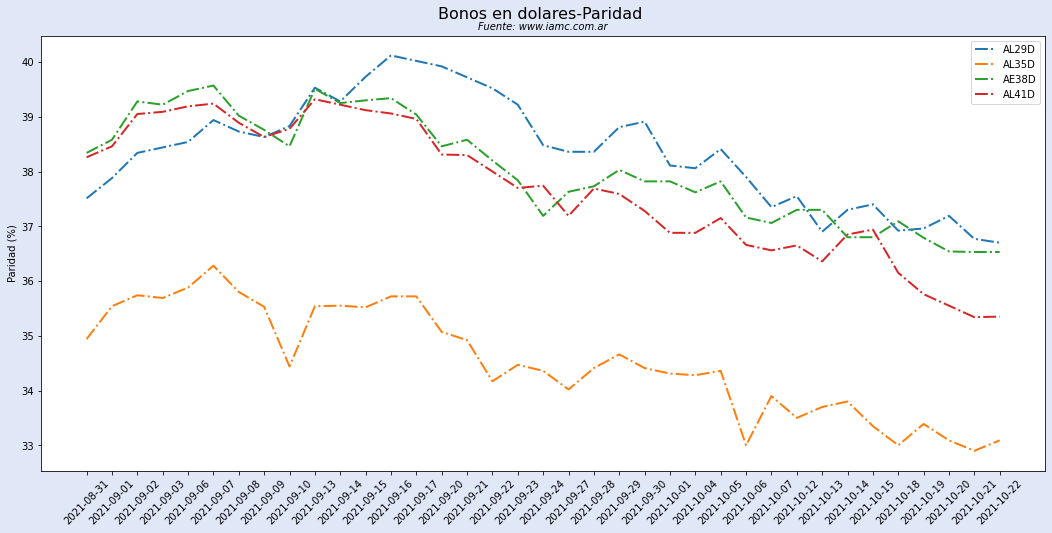

In [37]:
grafica_paridad(df_dolares_alphacast, moneda="dolares", bonos = ["AL29D","AL35D", "AE38D", "AL41D"])


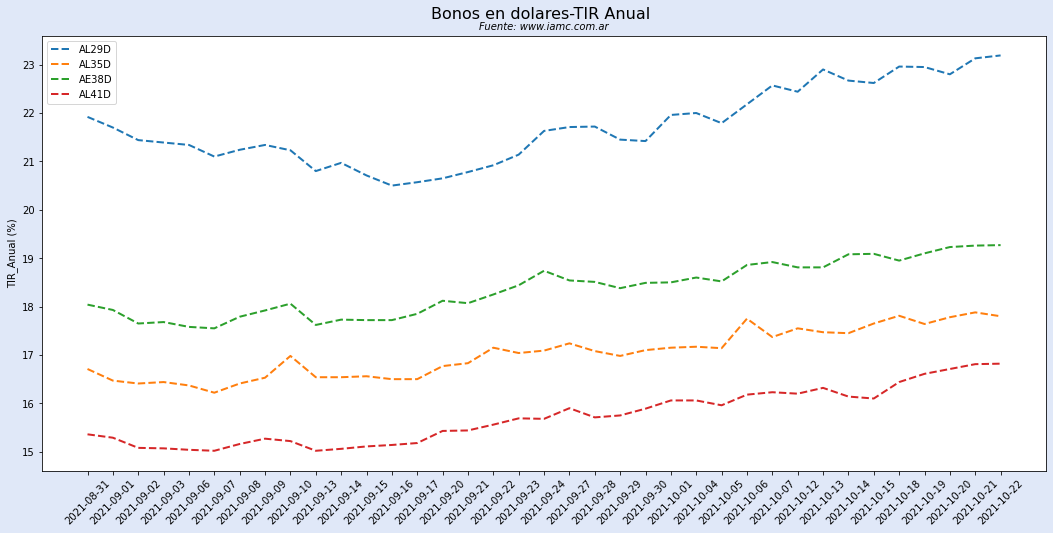

In [38]:
grafica_TIR_anual(df_dolares_alphacast, "dolares", bonos = ["AL29D","AL35D", "AE38D", "AL41D"])

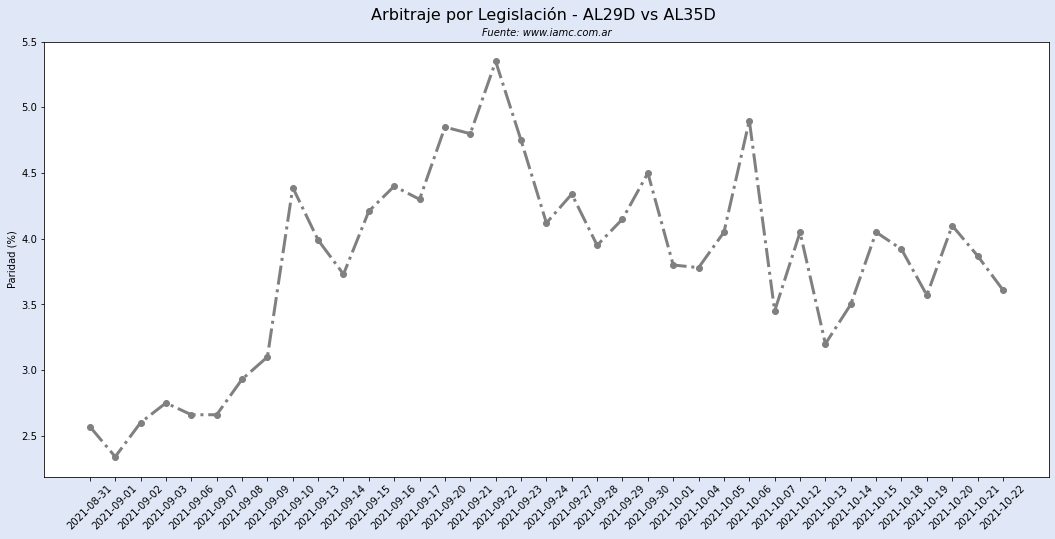

In [39]:
grafica_arbitraje_x_legislacion(df_dolares_alphacast, "AL29D", "AL35D")

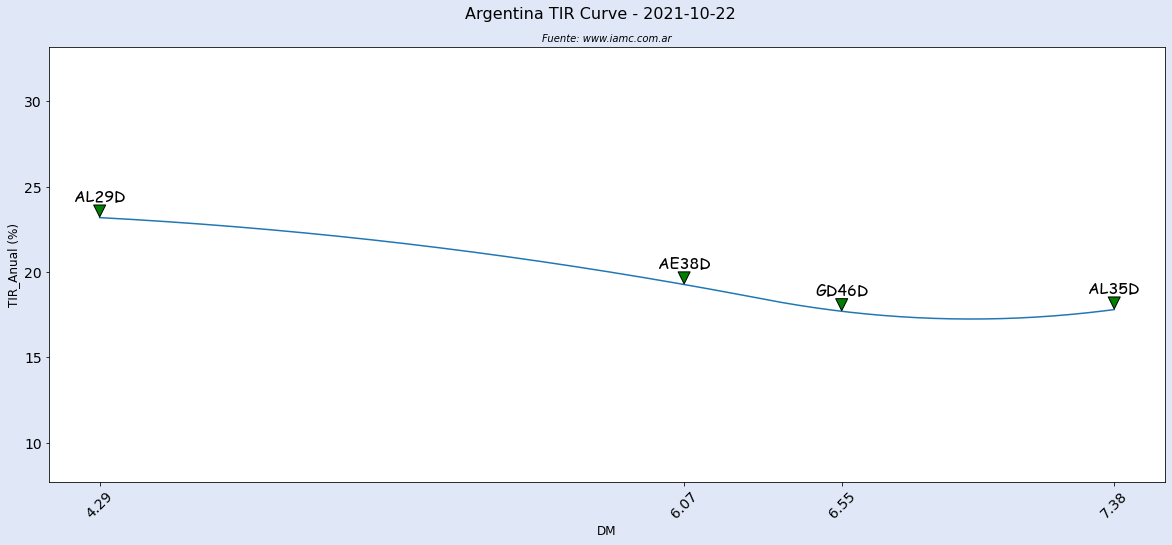

In [40]:
Argentina_TIR_Curve(df_dolares_alphacast, bonos_dolares_yc=[ "AL29D","AL35D","GD46D","AE38D"])

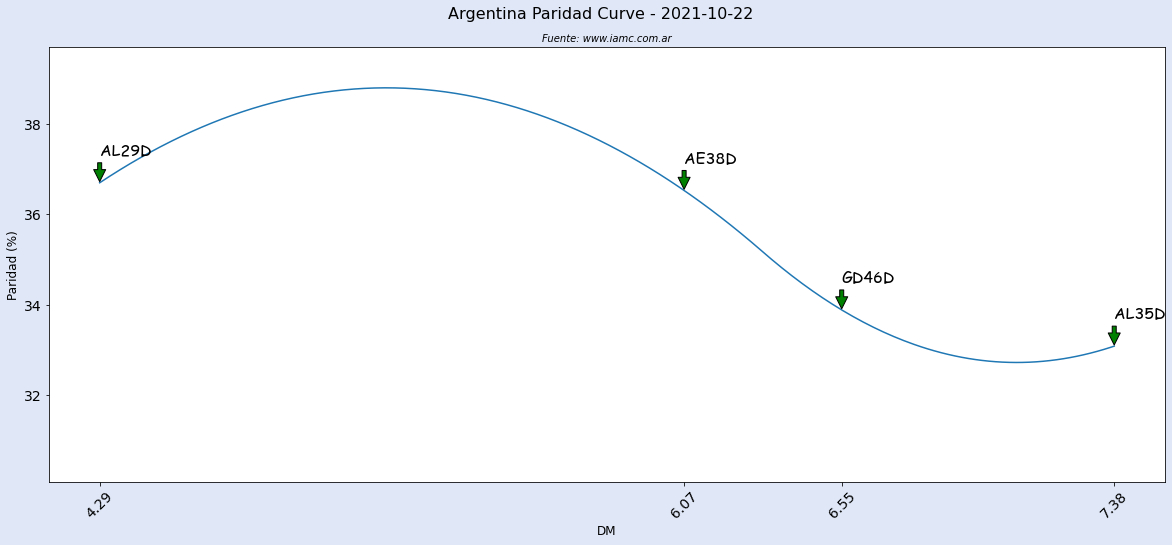

In [41]:
Argentina_Paridad_Curve(df_dolares_alphacast, bonos_dolares_yc=["AL29D","AL35D", "GD46D", "AE38D"])

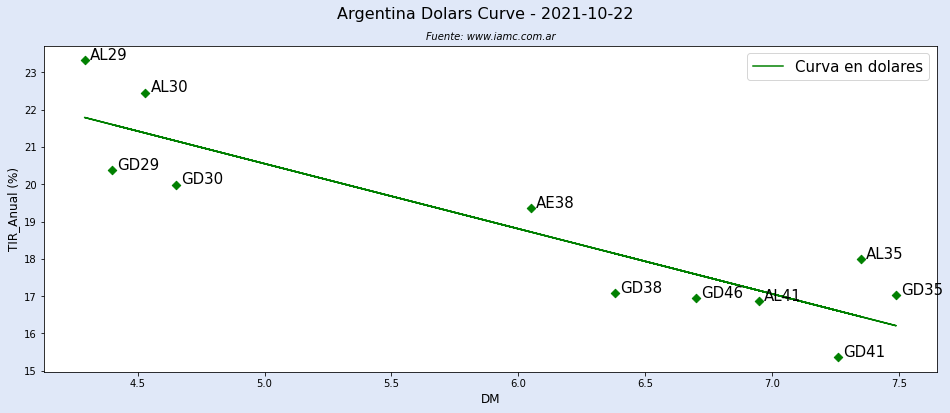

In [42]:
Argentina_Dolars_Curve(df_dolares_alphacast, bonos_dolares_yc=['AL29','AL30','AL35', "AE38", 'AL41', 'GD29', 'GD30', 'GD35','GD38','GD41',
                                                        'GD46'])

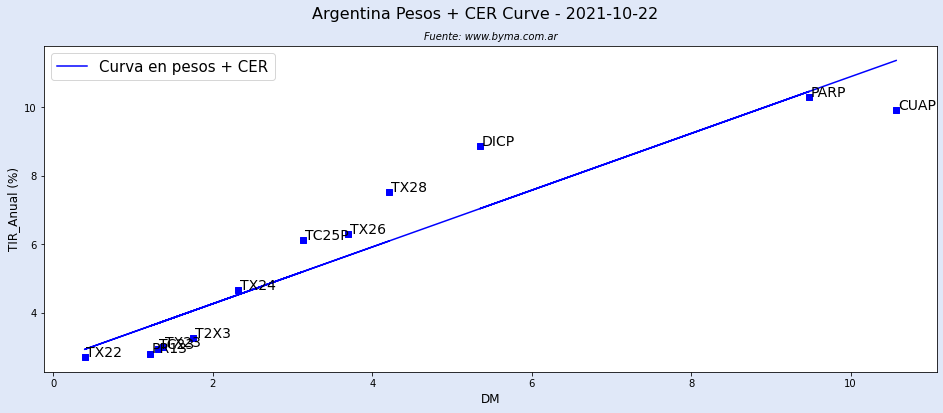

In [43]:
Argentina_Pesos_Curve(bonos_pesos, bonos_pesos_yc=['TX22','PR13', 'TX23', 'TC23','T2X3', 'TX24', 'TC25P', 'TX26','TX28', 'DICP',
                                                   'PARP', 'CUAP'])

In [44]:
fin = time.time()
print(fin-inicio) 

24.59233856201172
